### Importing Libraries and IBM PAIRS Authentication

In [1]:
import pandas as pd
from ibmpairs import paw, authentication
import json
import numpy
from datetime import datetime, timedelta
import logging
import matplotlib.pyplot as plt
import re
import numpy as np

In [2]:
logging.basicConfig(level=logging.INFO)
pawLogger = logging.getLogger('ibmpairs.paw')
pawLogger.setLevel(logging.INFO)

In [3]:
with open("./ibmpairskey.txt", "r") as f:
    pairs_key = f.read()

In [4]:
pairs_credentials = authentication.OAuth2(api_key=pairs_key)
auth_header = {'Authorization': f'Bearer {pairs_credentials.jwt_token}'}
PAIRS_SERVER   = 'https://pairs.res.ibm.com'
PAIRS_CREDENTIALS = authentication.OAuth2(api_key=pairs_key)

In [5]:
iso8601 = '%Y-%m-%dT%H:%M:%SZ'

### Sentinel 2: Red, Green, Blue, NIR, NDVI

Defining layers, dates and region of interest and
Testing Max Query Limit

In [6]:
rgbNirNdviSCLLayers = {
    'Red' : '49360',
    'Green' : '49681',
    'Blue' : '49680',
    'NIR': '49361',
    'NDVI' : '49464',
    'SCL': '49362',
    'SWIR1': '49687',
    'SWIR2': '49686'
}

In [7]:
dates = {
    '20150801' : datetime(2015, 8, 1, 12).strftime(iso8601),
    '20150901' : datetime(2015, 9, 1, 12).strftime(iso8601)
}

bbox = ["46.94599", "7.68597", "47.20599", "7.94597"] # around Bern

In [8]:
queryJson = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviSCLLayers[lKey],
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviSCLLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : bbox }, 
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2015, 8, 1, 12).strftime(iso8601), "end" : datetime(2015, 9, 1, 12).strftime(iso8601)
        # "snapshot" : datetime(2021, 6, 13).strftime(iso8601),
    }
    ]}
}

In [9]:
query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Alright, using cache of PAIRS query with ID: '1663560000_34396340'


In [10]:
query.poll_till_finished()
query.download()
query.create_layers()

INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663560000_34396340_38dcc7b11703393477d4816b0ed92448.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


In [11]:
query.metadata

{'High res  imagery (ESA Sentinel 2)-Band 12 (SWIR 2200 nm)-08_29_2015T00_00_00': {'datalayerId': '49687',
  'datalayerName': 'Band 12 (SWIR 2200 nm)',
  'timestamp': datetime.datetime(2015, 8, 29, 0, 0, tzinfo=<UTC>),
  'layerType': 'raster',
  'details': {'pixelType': 'fl',
   'pixelNoDataVal': -9999.0,
   'spatialRef': 'EPSG:4326',
   'boundingBox': {'minLatitude': 46.945664,
    'maxLatitude': 47.207808,
    'minLongitude': 7.684864,
    'maxLongitude': 7.947008},
   'pixelDimensions': {'pixelSizeDegreeLongitude': 6.4e-05,
    'pixelSizeDegreeLatitude': 6.4e-05,
    'numberPixelsLatitude': 4096,
    'numberPixelsLongitude': 4096},
   'rasterStatistics': {'pixelMin': 0.0048,
    'pixelMax': 1.5043,
    'pixelCount': 16507969,
    'pixelMean': 0.099905,
    'pixelStandardDeviation': 0.055922}}},
 'High res  imagery (ESA Sentinel 2)-Band 8 (NIR)-08_26_2015T00_00_00': {'datalayerId': '49361',
  'datalayerName': 'Band 8 (NIR)',
  'timestamp': datetime.datetime(2015, 8, 26, 0, 0, tzinfo=

In [12]:
response_format = "%m_%d_%YT%H_%M_%S"
layers_df = pd.DataFrame([k.split("-") for k in query.metadata], columns=["dataset", "band", "date"])
layers_df["pixelMin"] = [query.metadata[k]["details"]["rasterStatistics"]["pixelMin"] for k in query.metadata]
layers_df["pixelMax"] = [query.metadata[k]["details"]["rasterStatistics"]["pixelMax"] for k in query.metadata]
layers_df["layerKey"] = query.metadata.keys()
layers_df["date"] = pd.to_datetime(layers_df["date"], format=response_format)

In [13]:
layers_df = layers_df.sort_values(by='date')
layers_df

,dataset,band,date,pixelMin,pixelMax,layerKey
25,High res imagery (ESA Sentinel 2),Band 4 (red),2015-08-06,0.0044,0.6507,High res imagery (ESA Sentinel 2)-Band 4 (red...
24,High res imagery (ESA Sentinel 2),Band 12 (SWIR 2200 nm),2015-08-06,0.0110,0.5050,High res imagery (ESA Sentinel 2)-Band 12 (SW...
8,High res imagery (ESA Sentinel 2),Normalized difference vegetation index,2015-08-06,-0.4036,0.9276,High res imagery (ESA Sentinel 2)-Normalized ...
20,High res imagery (ESA Sentinel 2),Band 11 (SWIR 1610 nm),2015-08-06,0.0196,0.6089,High res imagery (ESA Sentinel 2)-Band 11 (SW...
10,High res imagery (ESA Sentinel 2),Band 2 (blue),2015-08-06,0.0019,0.5574,High res imagery (ESA Sentinel 2)-Band 2 (blu...
33,High res imagery (ESA Sentinel 2),Scene classification,2015-08-06,2.0000,10.0000,High res imagery (ESA Sentinel 2)-Scene class...
16,High res imagery (ESA Sentinel 2),Band 8 (NIR),2015-08-06,0.0328,1.1087,High res imagery (ESA Sentinel 2)-Band 8 (NIR...
32,High res imagery (ESA Sentinel 2),Scene classification,2015-08-09,4.0000,10.0000,High res imagery (ESA Sentinel 2)-Scene class...
23,High res imagery (ESA Sentinel 2),Band 4 (red),2015-08-09,0.0590,1.6620,High res imagery (ESA Sentinel 2)-Band 4 (red...
22,High res imagery (ESA Sentinel 2),Band 12 (SWIR 2200 nm),2015-08-09,0.0428,0.7487,High res imagery (ESA Sentinel 2)-Band 12 (SW...


In [14]:
array = numpy.array(list(query.data.values()))
print(f'Data shape: {array.shape}')
print(f'Nbr of non zero and non missing vals: {np.count_nonzero(~np.isnan(array))}')
print(f'Nbr of missing vals: {np.count_nonzero(~np.isnan(array[1]))}')

Data shape: (44, 4096, 4096)
Nbr of non zero and non missing vals: 494811265
Nbr of missing vals: 5754117


## NDVI

In [15]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string_08_06 = query_metadata[
    (query_metadata['datalayerId'] == '49464') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-06-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_06]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_09 = query_metadata[
    (query_metadata['datalayerId'] == '49464') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-09-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_09]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_16 = query_metadata[
    (query_metadata['datalayerId'] == '49464') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-16-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_16]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_19 = query_metadata[
    (query_metadata['datalayerId'] == '49464') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-19-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_19]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_26 = query_metadata[
    (query_metadata['datalayerId'] == '49464') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-26-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_26]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_29 = query_metadata[
    (query_metadata['datalayerId'] == '49464') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-29-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_29]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

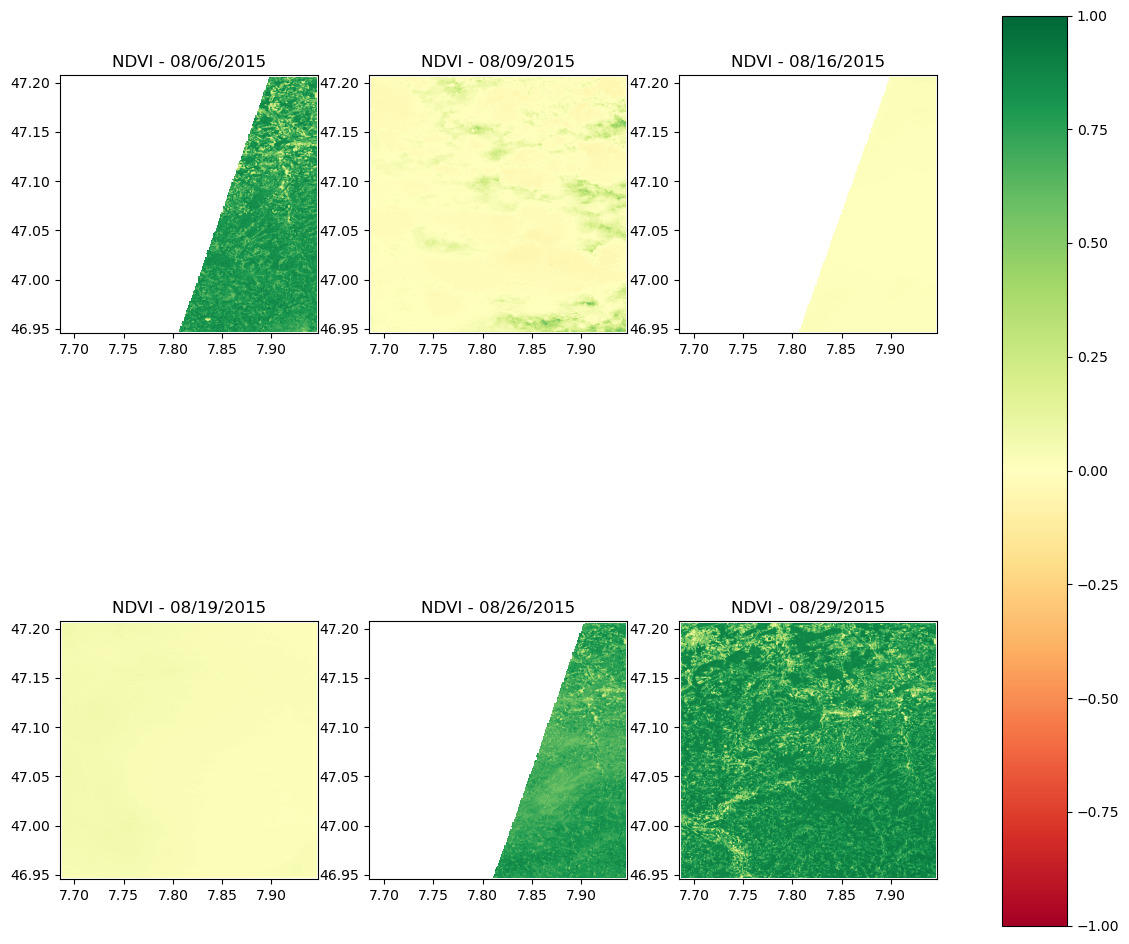

In [16]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_06 = axs[0,0].imshow(query.data[id_string_08_06], extent = extent,cmap = 'RdYlGn', vmin = -1, vmax = 1)
im_08_09 = axs[0,1].imshow(query.data[id_string_08_09], extent = extent,cmap = 'RdYlGn', vmin = -1, vmax = 1)
im_08_16 = axs[0,2].imshow(query.data[id_string_08_16], extent = extent,cmap = 'RdYlGn', vmin = -1, vmax = 1)
im_08_19 = axs[1,0].imshow(query.data[id_string_08_19], extent = extent,cmap = 'RdYlGn', vmin = -1, vmax = 1)
im_08_26 = axs[1,1].imshow(query.data[id_string_08_26], extent = extent,cmap = 'RdYlGn', vmin = -1, vmax = 1)
im_08_29 = axs[1,2].imshow(query.data[id_string_08_29], extent = extent, cmap = 'RdYlGn', vmin = -1, vmax = 1)
axs[0,0].set_title('NDVI - 08/06/2015')
axs[0,1].set_title('NDVI - 08/09/2015')
axs[0,2].set_title('NDVI - 08/16/2015')
axs[1,0].set_title('NDVI - 08/19/2015')
axs[1,1].set_title('NDVI - 08/26/2015')
axs[1,2].set_title('NDVI - 08/29/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_06, cax=cbar_ax)
plt.show()

### Fill NaN values with mean

In [ ]:
#Find mean
col_mean = np.nanmean(query.data[id_string_08_06])

In [ ]:
#Find indices that you need to replace
inds = np.where(np.isnan(query.data[id_string_08_06]))

In [ ]:
query.data[id_string_08_06][inds] = col_mean

In [ ]:
query.data[id_string_08_06]

In [ ]:
plt.imshow(query.data[id_string_08_06], extent = extent, cmap = 'RdYlGn')
plt.colorbar()
plt.show()

### GREEN

In [17]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string_08_06_green = query_metadata[
    (query_metadata['datalayerId'] == '49681') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-06-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_06_green]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_09_green = query_metadata[
    (query_metadata['datalayerId'] == '49681') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-09-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_09_green]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_16_green = query_metadata[
    (query_metadata['datalayerId'] == '49681') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-16-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_16_green]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_19_green = query_metadata[
    (query_metadata['datalayerId'] == '49681') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-19-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_19_green]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_26_green = query_metadata[
    (query_metadata['datalayerId'] == '49681') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-26-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_26_green]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_29_green = query_metadata[
    (query_metadata['datalayerId'] == '49681') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-29-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_29_green]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

IndexError: index 0 is out of bounds for axis 0 with size 0

NameError: name 'id_string_08_06_green' is not defined

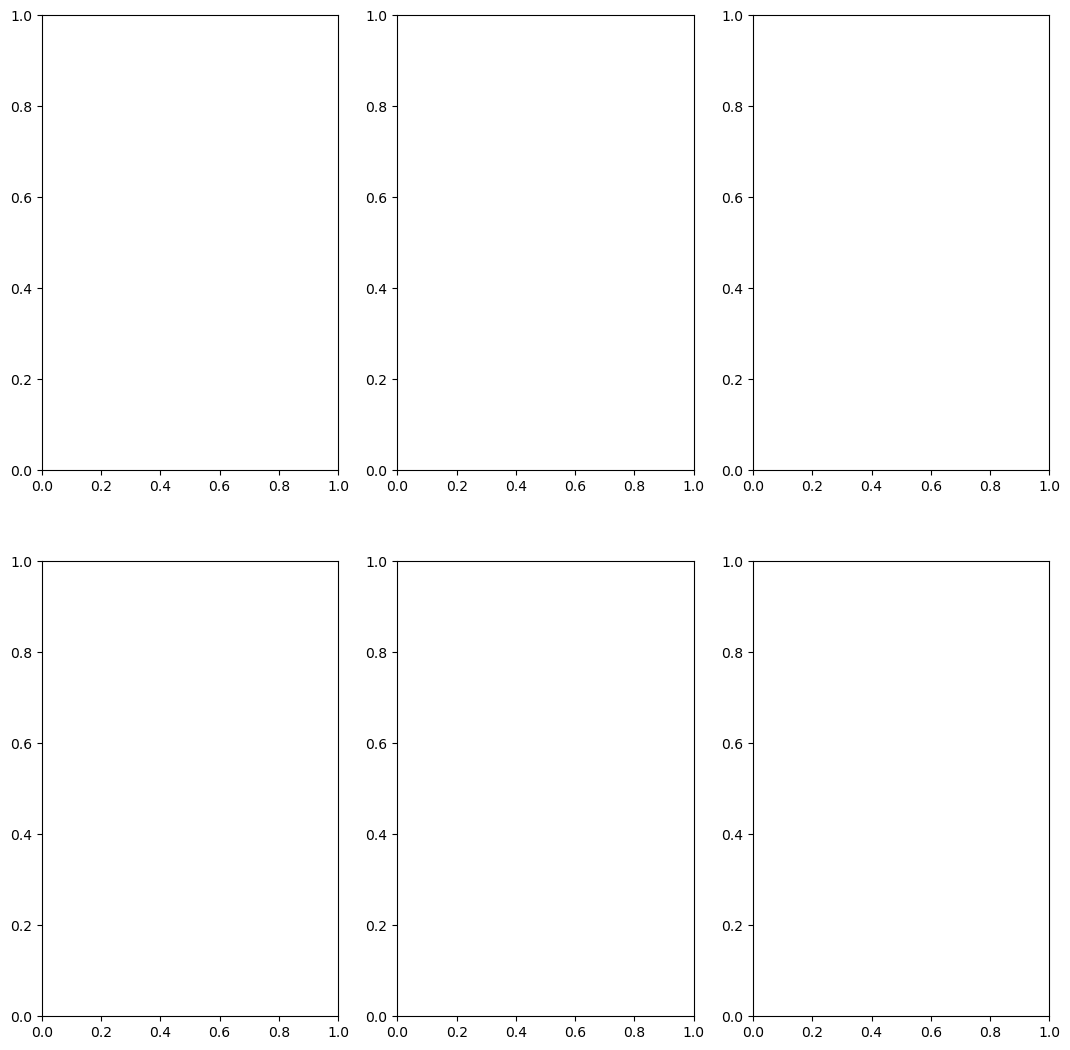

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_06_green = axs[0,0].imshow(query.data[id_string_08_06_green], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_09_green = axs[0,1].imshow(query.data[id_string_08_09_green], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_16_green = axs[0,2].imshow(query.data[id_string_08_16_green], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_19_green = axs[1,0].imshow(query.data[id_string_08_19_green], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_26_green = axs[1,1].imshow(query.data[id_string_08_26_green], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_29_green = axs[1,2].imshow(query.data[id_string_08_29_green], extent = extent, cmap = 'RdYlGn', vmin = 0, vmax = 1)
axs[0,0].set_title('Band Green - 08/06/2015')
axs[0,1].set_title('Band Green - 08/09/2015')
axs[0,2].set_title('Band Green - 08/16/2015')
axs[1,0].set_title('Band Green - 08/19/2015')
axs[1,1].set_title('Band Green - 08/26/2015')
axs[1,2].set_title('Band Green - 08/29/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_06_green, cax=cbar_ax)
plt.show()

## RED

In [18]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string_08_06_red = query_metadata[
    (query_metadata['datalayerId'] == '49360') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-06-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_06_red]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_09_red = query_metadata[
    (query_metadata['datalayerId'] == '49360') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-09-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_09_red]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_16_red = query_metadata[
    (query_metadata['datalayerId'] == '49360') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-16-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_16_red]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_19_red = query_metadata[
    (query_metadata['datalayerId'] == '49360') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-19-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_19_red]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_26_red = query_metadata[
    (query_metadata['datalayerId'] == '49360') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-26-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_26_red]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_29_red = query_metadata[
    (query_metadata['datalayerId'] == '49360') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-29-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_29_red]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

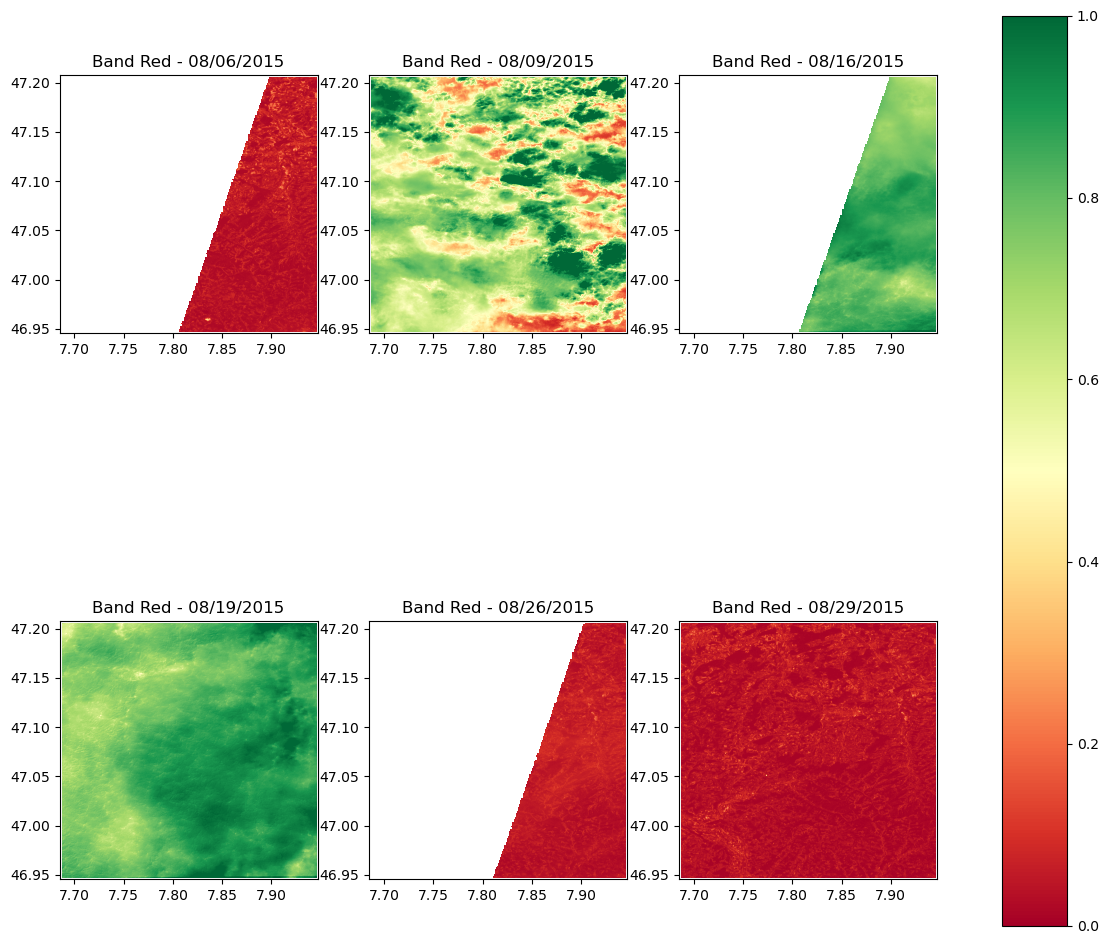

In [25]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_06_red = axs[0,0].imshow(query.data[id_string_08_06_red], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_09_red = axs[0,1].imshow(query.data[id_string_08_09_red], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_16_red = axs[0,2].imshow(query.data[id_string_08_16_red], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_19_red = axs[1,0].imshow(query.data[id_string_08_19_red], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_26_red = axs[1,1].imshow(query.data[id_string_08_26_red], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_29_red = axs[1,2].imshow(query.data[id_string_08_29_red], extent = extent, cmap = 'RdYlGn', vmin = 0, vmax = 1)
axs[0,0].set_title('Band Red - 08/06/2015')
axs[0,1].set_title('Band Red - 08/09/2015')
axs[0,2].set_title('Band Red - 08/16/2015')
axs[1,0].set_title('Band Red - 08/19/2015')
axs[1,1].set_title('Band Red - 08/26/2015')
axs[1,2].set_title('Band Red - 08/29/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_06_red, cax=cbar_ax)
plt.show()

## BLUE

In [20]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string_08_06_blue = query_metadata[
    (query_metadata['datalayerId'] == '49680') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-06-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_06_blue]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_09_blue = query_metadata[
    (query_metadata['datalayerId'] == '49680') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-09-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_09_blue]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_16_blue = query_metadata[
    (query_metadata['datalayerId'] == '49680') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-16-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_16_blue]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_19_blue = query_metadata[
    (query_metadata['datalayerId'] == '49680') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-19-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_19_red]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_26_blue = query_metadata[
    (query_metadata['datalayerId'] == '49680') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-26-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_26_blue]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_29_blue = query_metadata[
    (query_metadata['datalayerId'] == '49680') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-29-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_29_blue]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

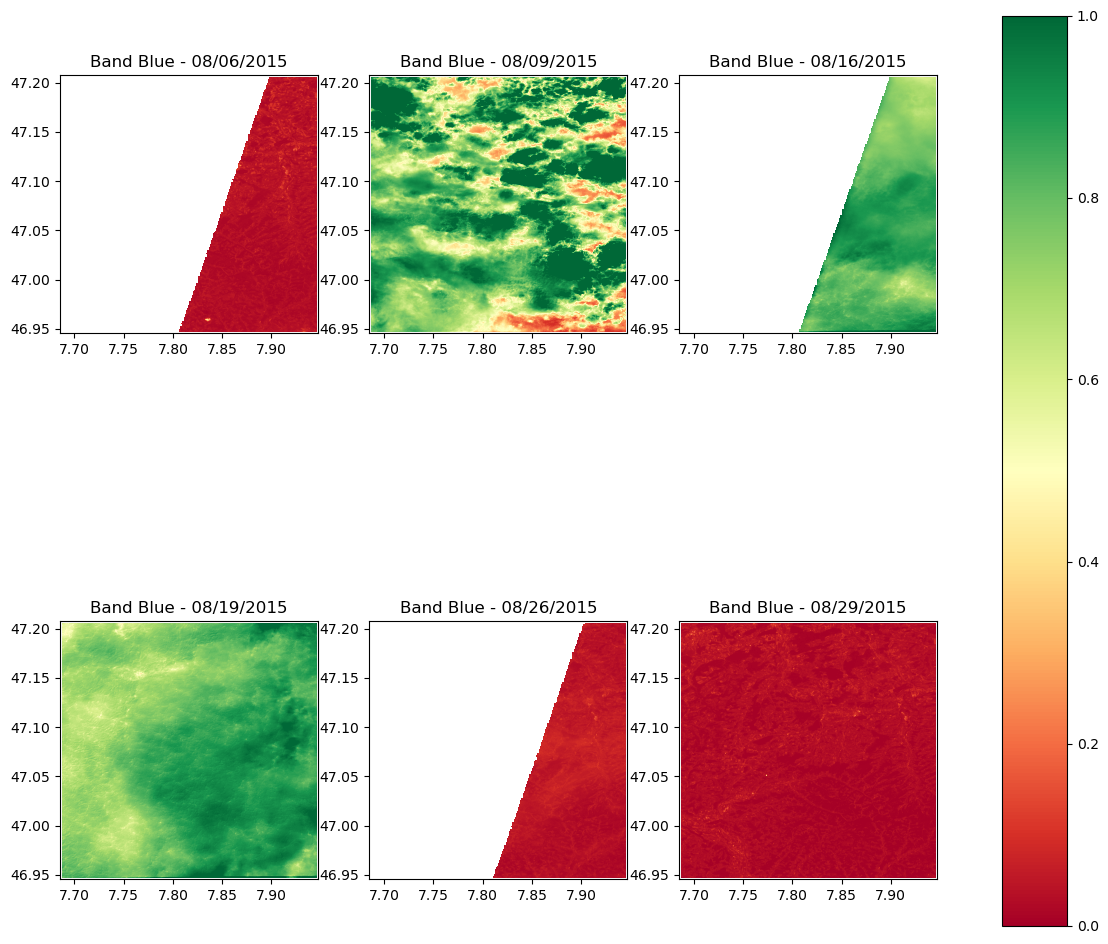

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_06_blue = axs[0,0].imshow(query.data[id_string_08_06_blue], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_09_blue = axs[0,1].imshow(query.data[id_string_08_09_blue], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_16_blue = axs[0,2].imshow(query.data[id_string_08_16_blue], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_19_blue = axs[1,0].imshow(query.data[id_string_08_19_blue], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_26_blue = axs[1,1].imshow(query.data[id_string_08_26_blue], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_29_blue = axs[1,2].imshow(query.data[id_string_08_29_blue], extent = extent, cmap = 'RdYlGn', vmin = 0, vmax = 1)
axs[0,0].set_title('Band Blue - 08/06/2015')
axs[0,1].set_title('Band Blue - 08/09/2015')
axs[0,2].set_title('Band Blue - 08/16/2015')
axs[1,0].set_title('Band Blue - 08/19/2015')
axs[1,1].set_title('Band Blue - 08/26/2015')
axs[1,2].set_title('Band Blue - 08/29/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_06_red, cax=cbar_ax)
plt.show()

## NIR

In [22]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string_08_06_nir = query_metadata[
    (query_metadata['datalayerId'] == '49361') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-06-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_06_nir]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_09_nir = query_metadata[
    (query_metadata['datalayerId'] == '49361') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-09-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_09_nir]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_16_nir = query_metadata[
    (query_metadata['datalayerId'] == '49361') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-16-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_16_nir]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_19_nir = query_metadata[
    (query_metadata['datalayerId'] == '49361') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-19-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_19_nir]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_26_nir = query_metadata[
    (query_metadata['datalayerId'] == '49361') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-26-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_26_nir]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_29_nir = query_metadata[
    (query_metadata['datalayerId'] == '49361') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-29-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_29_nir]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

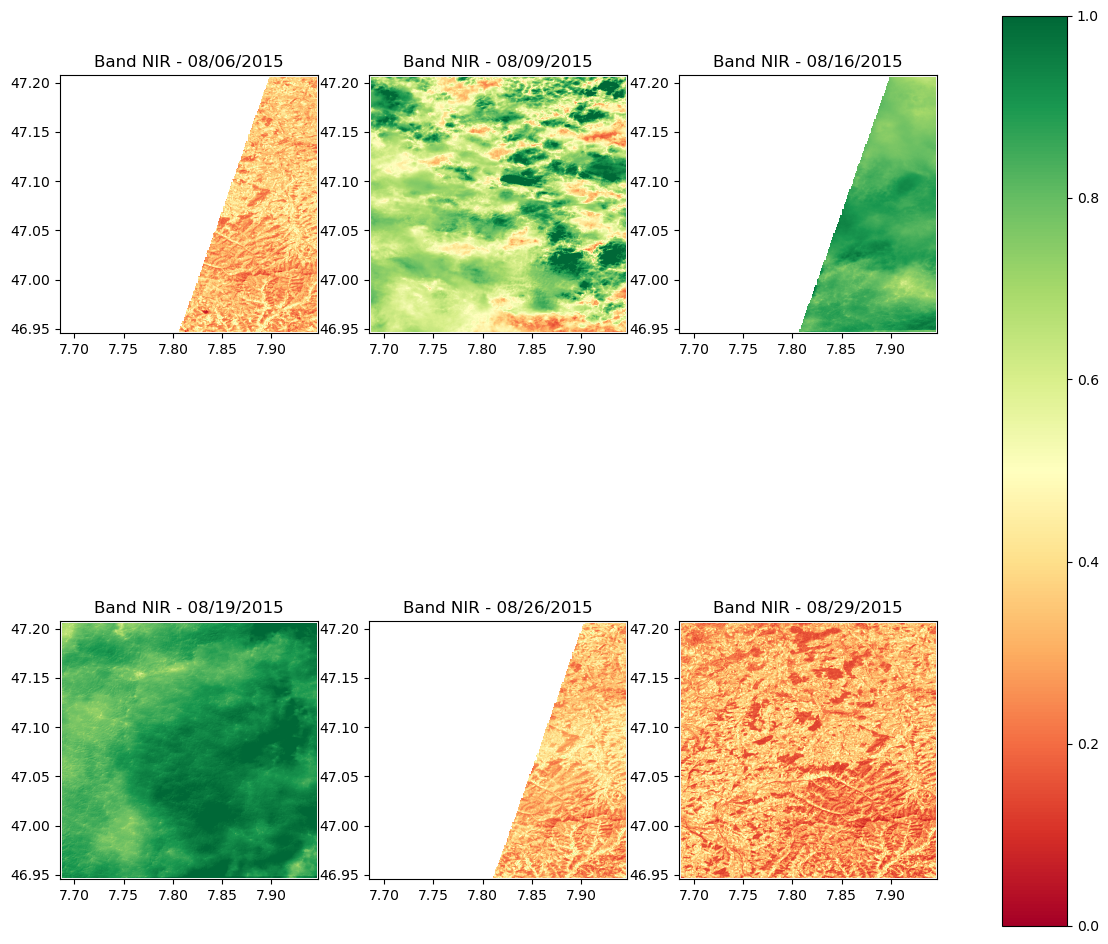

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_06_nir = axs[0,0].imshow(query.data[id_string_08_06_nir], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_09_nir = axs[0,1].imshow(query.data[id_string_08_09_nir], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_16_nir = axs[0,2].imshow(query.data[id_string_08_16_nir], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_19_nir = axs[1,0].imshow(query.data[id_string_08_19_nir], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_26_nir = axs[1,1].imshow(query.data[id_string_08_26_nir], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_29_nir = axs[1,2].imshow(query.data[id_string_08_29_nir], extent = extent, cmap = 'RdYlGn', vmin = 0, vmax = 1)
axs[0,0].set_title('Band NIR - 08/06/2015')
axs[0,1].set_title('Band NIR - 08/09/2015')
axs[0,2].set_title('Band NIR - 08/16/2015')
axs[1,0].set_title('Band NIR - 08/19/2015')
axs[1,1].set_title('Band NIR - 08/26/2015')
axs[1,2].set_title('Band NIR - 08/29/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_06_red, cax=cbar_ax)
plt.show()

# SCL

In [98]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string_08_06_scl = query_metadata[
    (query_metadata['datalayerId'] == '49362') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-06-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_06_scl]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_09_scl = query_metadata[
    (query_metadata['datalayerId'] == '49362') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-09-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_09_scl]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_16_scl = query_metadata[
    (query_metadata['datalayerId'] == '49362') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-16-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_16_scl]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_19_scl = query_metadata[
    (query_metadata['datalayerId'] == '49362') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-19-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_19_scl]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_26_scl = query_metadata[
    (query_metadata['datalayerId'] == '49362') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-26-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_26_scl]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_29_scl = query_metadata[
    (query_metadata['datalayerId'] == '49362') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-29-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_29_scl]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

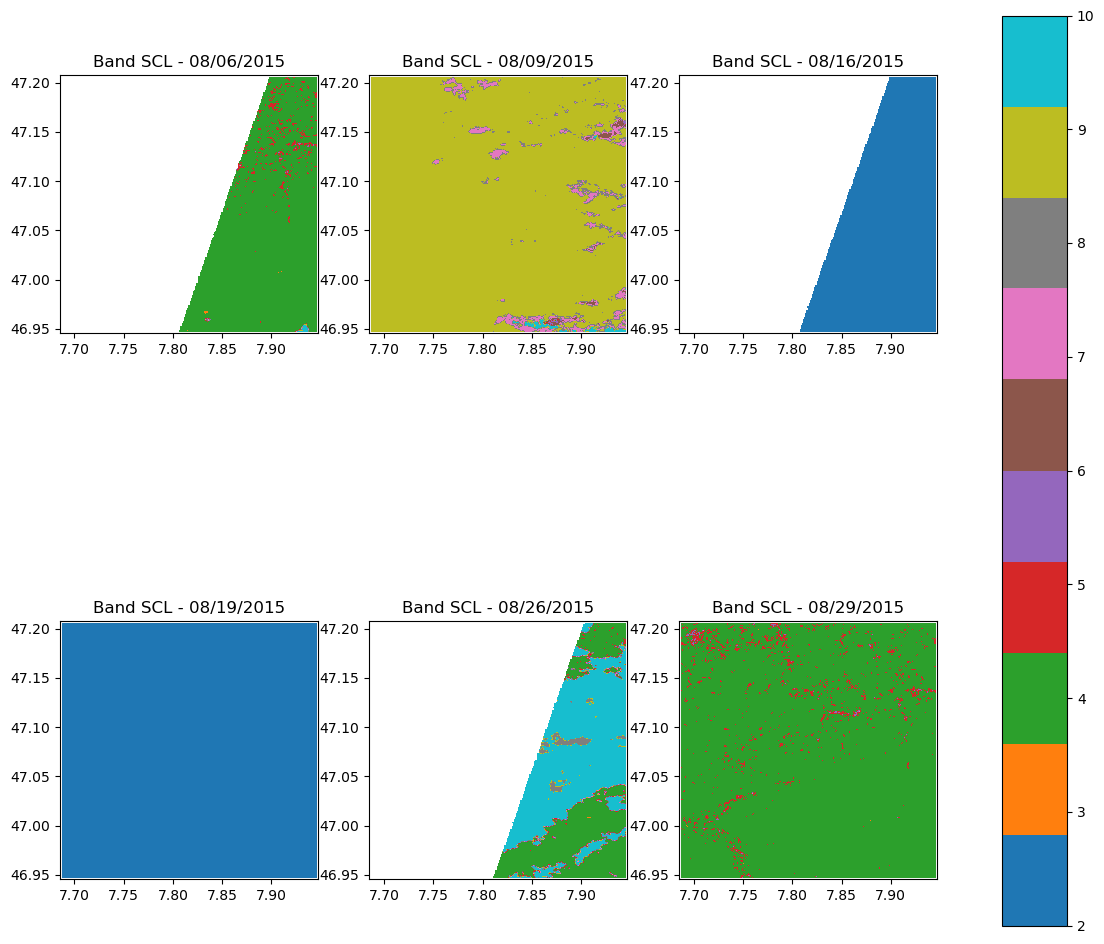

In [105]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_06_scl = axs[0,0].imshow(query.data[id_string_08_06_scl], extent = extent,cmap = 'tab10')
im_08_09_scl = axs[0,1].imshow(query.data[id_string_08_09_scl], extent = extent,cmap = 'tab10')
im_08_16_scl = axs[0,2].imshow(query.data[id_string_08_16_scl], extent = extent,cmap = 'tab10')
im_08_19_scl = axs[1,0].imshow(query.data[id_string_08_19_scl], extent = extent,cmap = 'tab10')
im_08_26_scl = axs[1,1].imshow(query.data[id_string_08_26_scl], extent = extent,cmap = 'tab10')
im_08_29_scl = axs[1,2].imshow(query.data[id_string_08_29_scl], extent = extent, cmap = 'tab10')
axs[0,0].set_title('Band SCL - 08/06/2015')
axs[0,1].set_title('Band SCL - 08/09/2015')
axs[0,2].set_title('Band SCL - 08/16/2015')
axs[1,0].set_title('Band SCL - 08/19/2015')
axs[1,1].set_title('Band SCL - 08/26/2015')
axs[1,2].set_title('Band SCL - 08/29/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_06_scl, cax=cbar_ax)
plt.show()

# SWIR1
49687',
    'SWIR2': '49686'

In [28]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string_08_06_sw1 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-06-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_06_sw1]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_09_sw1 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-09-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_09_sw1]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_16_sw1 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-16-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_16_sw1]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_19_sw1 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-19-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_19_sw1]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_26_sw1 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-26-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_26_sw1]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_29_sw1 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-29-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_29_sw1]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

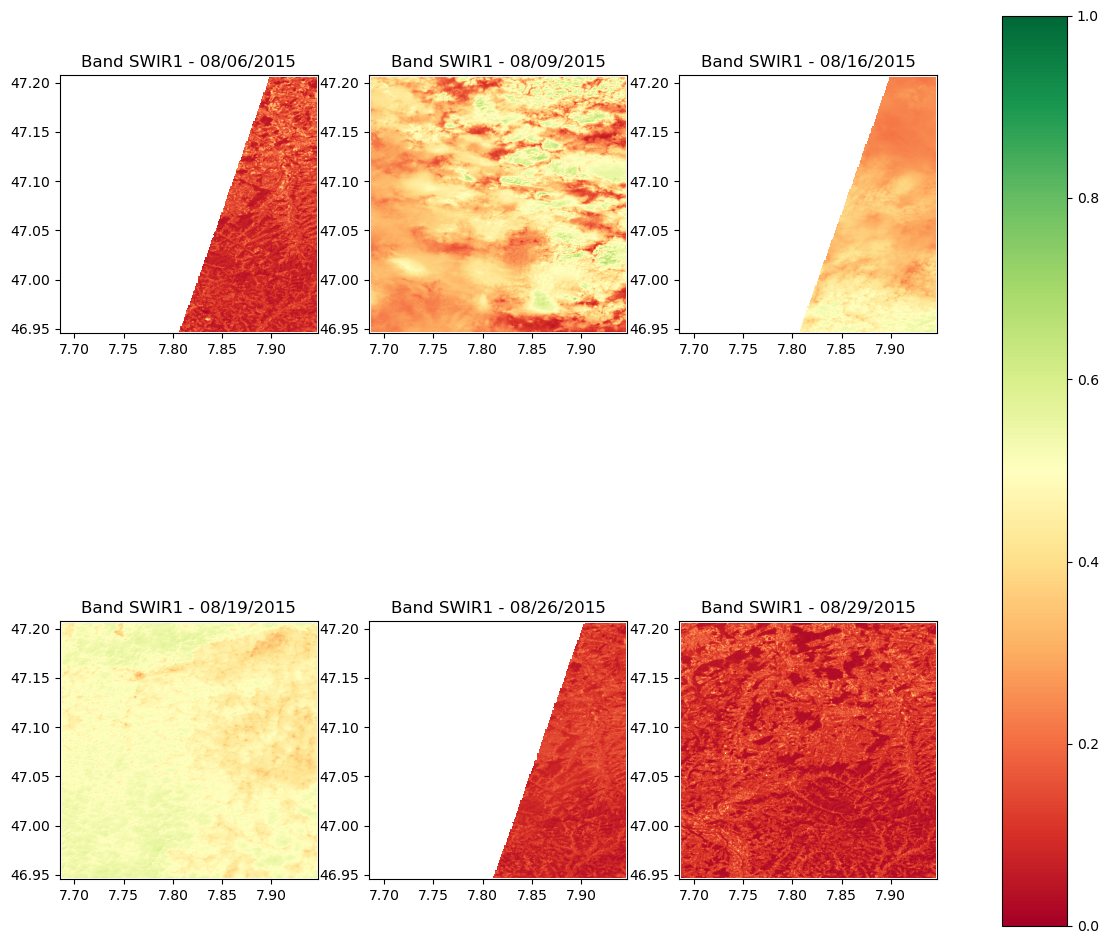

In [29]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_06_sw1 = axs[0,0].imshow(query.data[id_string_08_06_sw1], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_09_sw1 = axs[0,1].imshow(query.data[id_string_08_09_sw1], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_16_sw1 = axs[0,2].imshow(query.data[id_string_08_16_sw1], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_19_sw1 = axs[1,0].imshow(query.data[id_string_08_19_sw1], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_26_sw1 = axs[1,1].imshow(query.data[id_string_08_26_sw1], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_29_sw1 = axs[1,2].imshow(query.data[id_string_08_29_sw1], extent = extent, cmap = 'RdYlGn', vmin = 0, vmax = 1)
axs[0,0].set_title('Band SWIR1 - 08/06/2015')
axs[0,1].set_title('Band SWIR1 - 08/09/2015')
axs[0,2].set_title('Band SWIR1 - 08/16/2015')
axs[1,0].set_title('Band SWIR1 - 08/19/2015')
axs[1,1].set_title('Band SWIR1 - 08/26/2015')
axs[1,2].set_title('Band SWIR1 - 08/29/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_06_sw1, cax=cbar_ax)
plt.show()

# SWIR2

In [30]:
query_metadata = pd.DataFrame(query.metadata).transpose()

id_string_08_06_sw2 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-06-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_06_sw2]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_09_sw2 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-09-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_09_sw2]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_16_sw2 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-16-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_16_sw2]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_19_sw2 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-19-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_19_sw2]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_26_sw2 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-26-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_26_sw2]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

id_string_08_29_sw2 = query_metadata[
    (query_metadata['datalayerId'] == '49687') & \
    (query_metadata['timestamp'] == pd.to_datetime('08-29-2015T00:00:00Z'))
].index[0]
extent = [
    query.metadata[id_string_08_29_sw2]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

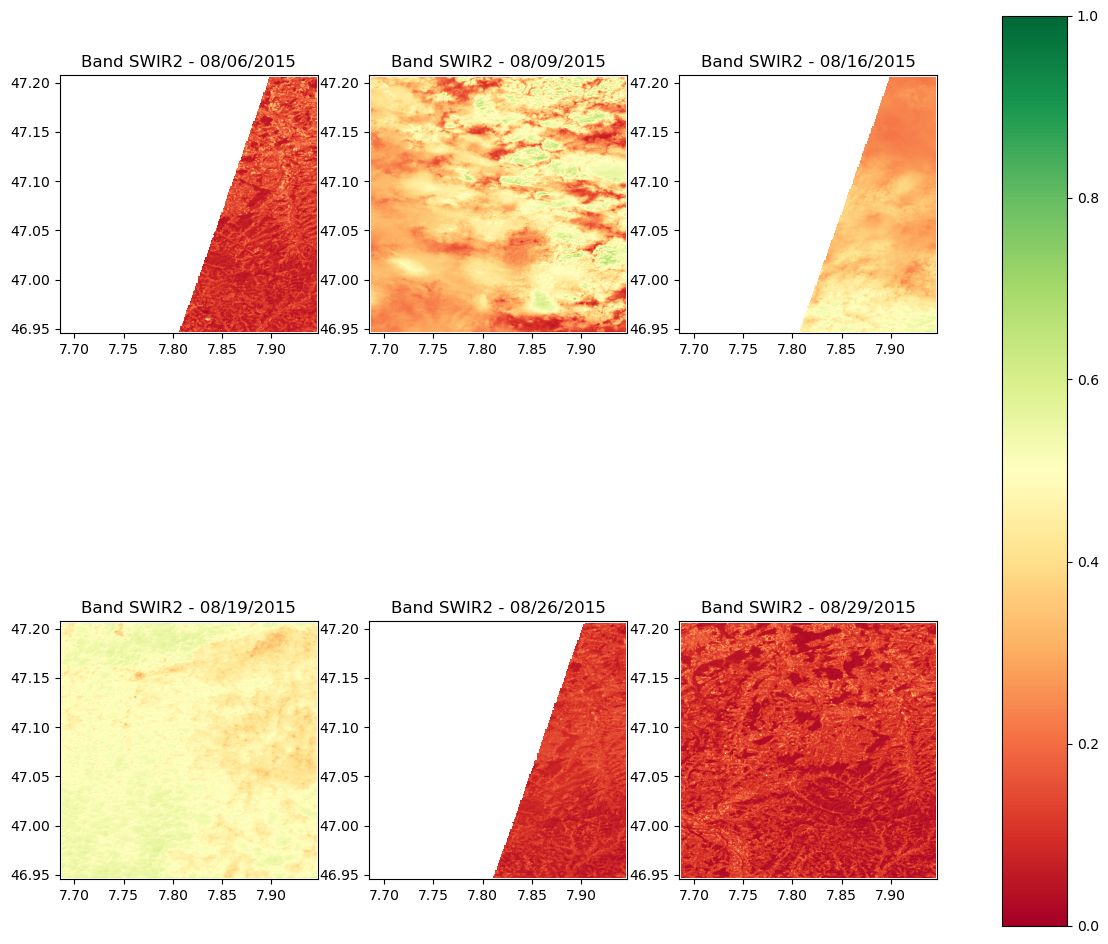

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(13, 13))
im_08_06_sw2 = axs[0,0].imshow(query.data[id_string_08_06_sw2], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_09_sw2 = axs[0,1].imshow(query.data[id_string_08_09_sw2], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_16_sw2 = axs[0,2].imshow(query.data[id_string_08_16_sw2], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_19_sw2 = axs[1,0].imshow(query.data[id_string_08_19_sw2], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_26_sw2 = axs[1,1].imshow(query.data[id_string_08_26_sw2], extent = extent,cmap = 'RdYlGn', vmin = 0, vmax = 1)
im_08_29_sw2 = axs[1,2].imshow(query.data[id_string_08_29_sw2], extent = extent, cmap = 'RdYlGn', vmin = 0, vmax = 1)
axs[0,0].set_title('Band SWIR2 - 08/06/2015')
axs[0,1].set_title('Band SWIR2 - 08/09/2015')
axs[0,2].set_title('Band SWIR2 - 08/16/2015')
axs[1,0].set_title('Band SWIR2 - 08/19/2015')
axs[1,1].set_title('Band SWIR2 - 08/26/2015')
axs[1,2].set_title('Band SWIR2 - 08/29/2015')
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.subplots_adjust(right=0.8)
fig.colorbar(im_08_06_sw2, cax=cbar_ax)
plt.show()

## Loop over dates to retrieve Sentinel-2 data 

In [106]:
rgbNirNdviLayers = {
    'Red' : '49360',
    'Green' : '49681',
    'Blue' : '49680',
    'NIR': '49361',
    'NDVI' : '49464',
    'SCL': '49362'
}

bbox = ["46.94599", "7.68597", "47.20599", "7.94597"] # around Bern

date = None
queryJson = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey]
            # 'temporal' : {'snapshot' : [{date}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : bbox }, 
    "temporal" : {"intervals" : [{"snapshot" : date}]} 
}

In [107]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2015, 8, 1)
end_date = date(2015, 8, 5)

iso8601 = '%Y-%m-%dT%H:%M:%SZ'

for single_date in daterange(start_date, end_date):
    date = single_date.strftime(iso8601)
    queryJson["temporal"]["intervals"][0]["snapshot"] = date
    
    print(queryJson)
    
    try:    
        query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
        query.submit()

        query.poll_till_finished()
        query.download()
        query.create_layers()
        # Could add some data manipulation here and then save the data
    except:
        print('No data for this date')

INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49360'}, {'type': 'raster', 'id': '49681'}, {'type': 'raster', 'id': '49680'}, {'type': 'raster', 'id': '49361'}, {'type': 'raster', 'id': '49464'}, {'type': 'raster', 'id': '49362'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'snapshot': '2015-08-01T00:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_34003542
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_34003542_0930c7c0d10e4903c0b0fe37474f1cab.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49360'}, {'type': 'raster', 'id': '49681'}, {'type': 'raster', 'id': '49680'}, {'type': 'raster', 'id': '49361'}, {'type': 'raster', 'id': '49464'}, {'type': 'raster', 'id': '49362'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'snapshot': '2015-08-02T00:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_34093224
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


No data for this date
{'layers': [{'type': 'raster', 'id': '49360'}, {'type': 'raster', 'id': '49681'}, {'type': 'raster', 'id': '49680'}, {'type': 'raster', 'id': '49361'}, {'type': 'raster', 'id': '49464'}, {'type': 'raster', 'id': '49362'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'snapshot': '2015-08-03T00:00:00Z'}]}}
No data for this date
{'layers': [{'type': 'raster', 'id': '49360'}, {'type': 'raster', 'id': '49681'}, {'type': 'raster', 'id': '49680'}, {'type': 'raster', 'id': '49361'}, {'type': 'raster', 'id': '49464'}, {'type': 'raster', 'id': '49362'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'snapshot': '2015-08-04T00:00:00Z'}]}}
No data for this date


# Loop over dates to retrieve ERA-5 data 

In [75]:
eraLayers = {
    'Total Prec' : '49459',
    'SP' : '49439',
    'Temp' : '49423',
    'AWVC' : '49458'
}

date_start, date_end = None, None

bbox = ["46.94599", "7.68597", "47.20599", "7.94597"] # around Bern


queryJson = {
    'layers' : [
        {            
            'type' : 'raster', 'id' : eraLayers[lKey],
            "aggregation" : "Mean"
            #"temporal" : {"intervals" : [{"start" : date_start, "end" : date_end}]} # if you put date here, need to update them in loop (for every layer)
        }
        for lKey in eraLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : bbox }, 
    "temporal" : {"intervals" : [
      {"start" : date_start, "end" : date_end}
  ]}
}

In [76]:
from datetime import date, datetime, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = datetime(2016, 6, 1, 12)
end_date = datetime(2016, 6, 14, 12)
iso8601 = '%Y-%m-%dT%H:%M:%SZ'

for single_date in daterange(start_date, end_date):
    date_start = single_date.strftime(iso8601)
    date_end = (single_date + timedelta(1)).strftime(iso8601)
    queryJson["temporal"]["intervals"][0]["start"] = date_start
    queryJson["temporal"]["intervals"][0]["end"] = date_end    
    print(queryJson)
    
    try:    
        query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
        query.submit()

        query.poll_till_finished()
        query.download()
        query.create_layers()
        # Could add some data manipulation here and then save the data
    except:
        print('No data for this date')

INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-01T12:00:00Z', 'end': '2016-06-02T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_16588863
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_16588863_e6bbcdc17960a79574fa14ab8b0c2553.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-02T12:00:00Z', 'end': '2016-06-03T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_16727141
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_16727141_22eb02f82fccfb8dbf012916cbf80ad1.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-03T12:00:00Z', 'end': '2016-06-04T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_16855435
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_16855435_72b21cd93371e587bdf999d2ac67128e.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-04T12:00:00Z', 'end': '2016-06-05T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_16962247
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_16962247_a9fdfdd4c366ca90643487e2b89ba9a1.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-05T12:00:00Z', 'end': '2016-06-06T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_17037632
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_17037632_de7159b12cd794f3e15cf4f50c2761d0.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-06T12:00:00Z', 'end': '2016-06-07T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_17071274
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_17071274_d3372919cc941626a54efb63ee6e815c.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-07T12:00:00Z', 'end': '2016-06-08T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_17115181
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_17115181_af4facaddffa7c0e6b4564554ef6afb7.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-08T12:00:00Z', 'end': '2016-06-09T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_17148712
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_17148712_f25635f8defda981bad214bd5673574f.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-09T12:00:00Z', 'end': '2016-06-10T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_17182385
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_17182385_de1ecc392164b6343713aad5c476e8c0.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-10T12:00:00Z', 'end': '2016-06-11T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_17226252
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_17226252_9c9b2546ca8cf14caed7b5e271433bcb.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-11T12:00:00Z', 'end': '2016-06-12T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_17270323
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_17270323_fe6e1546e0416136187dc7d9128e9c0f.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-12T12:00:00Z', 'end': '2016-06-13T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_17303854
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_17303854_f7197158f84f316ad281b155716b892b.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.


{'layers': [{'type': 'raster', 'id': '49459', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49439', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49423', 'aggregation': 'Mean'}, {'type': 'raster', 'id': '49458', 'aggregation': 'Mean'}], 'spatial': {'type': 'square', 'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']}, 'temporal': {'intervals': [{'start': '2016-06-13T12:00:00Z', 'end': '2016-06-14T12:00:00Z'}]}}


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_17477145
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663300800_17477145_b8b17e6723d28f7e174c602e27cb3cd7.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


# Loop over dates for Sentinel-2 + ERA5

In [23]:
# Sentinel 2

rgbNirNdviLayers = {
    'Red' : '49360',
    'Green' : '49681',
    'Blue' : '49680',
    'NIR': '49361',
    'NDVI' : '49464',
    'SCL': '49362'
}

bbox = ["46.94599", "7.68597", "47.20599", "7.94597"] # around Bern

date = None
queryJson_sen = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviLayers[lKey]
            # 'temporal' : {'snapshot' : [{date}]},
            # 'output' : False
        }
        for lKey in rgbNirNdviLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : bbox }, 
    "temporal" : {"intervals" : [{"snapshot" : date}]} 
}


# ERA 5

eraLayers = {
    'Total Prec' : '49459',
    'SP' : '49439',
    'Temp' : '49423',
    'AWVC' : '49458'
}

date_start, date_end = None, None

queryJson_era = {
    'layers' : [
        {            
            'type' : 'raster', 'id' : eraLayers[lKey],
            "aggregation" : "Mean"
            #"temporal" : {"intervals" : [{"start" : date_start, "end" : date_end}]} # if you put date here, need to update them in loop (for every layer)
        }
        for lKey in eraLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : bbox }, 
    "temporal" : {"intervals" : [
      {"start" : date_start, "end" : date_end}
  ]}
}

In [24]:
from datetime import date, timedelta

def daterange(start_date, end_date):
    for n in range(int((end_date - start_date).days)):
        yield start_date + timedelta(n)

start_date = date(2016, 8, 1)
end_date = date(2016, 8, 14)

iso8601 = '%Y-%m-%dT%H:%M:%SZ'

for single_date in daterange(start_date, end_date):
    
    # Try Sentinel 2 first
    
    date = single_date.strftime(iso8601)
    queryJson_sen["temporal"]["intervals"][0]["snapshot"] = date
    #print(queryJson_sen)
    sentinel_check = 0 # to check if there is Sentinel 2 data for this date or not
    
    try:    
        query = paw.PAIRSQuery(queryJson_sen, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
        query.submit()

        query.poll_till_finished()
        query.download()
        query.create_layers()
        # Could add some data manipulation here and then save the data
        sentinel_check = 1
    except:
        print('No Sentinel-2 data for this date')
        
    if sentinel_check:
        # Now download ERA 5 for dates of Sentinel 2
        date_start = single_date.strftime(iso8601)
        date_end = (single_date + timedelta(1)).strftime(iso8601)
        queryJson_era["temporal"]["intervals"][0]["start"] = date_start
        queryJson_era["temporal"]["intervals"][0]["end"] = date_end    
        #print(queryJson_era)

        try:    
            query = paw.PAIRSQuery(queryJson_era, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
            query.submit()

            query.poll_till_finished()
            query.download()
            query.create_layers()
            # Could add some data manipulation here and then save the data
        except:
            print('No ERA 5 data for this date')
        

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_27652275
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663560000_27652275_461aca71893f5626c0c1561ca61ea8d7.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_27880219
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663560000_27880219_49a4cea9b7b12f381072130e540e7e16.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_27914156
IN

No Sentinel-2 data for this date


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_27957562
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663560000_27957562_9a0a268ed0d7814dc328f87b6276d884.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28223068
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663560000_28223068_a6b8c372d7b27c3aeaba330222c9ee97.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28256566
INFO:ibmpairs.paw:Here we go, PAIRS query result s

No Sentinel-2 data for this date


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28428841
INFO:ibmpairs.paw:Bummer, the PAIRS query finished, but you'll never be able to download anything, status code: '21' (NoDataFound)
INFO:ibmpairs.paw:PAIRS query JSON initialized.


No Sentinel-2 data for this date


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28461720
INFO:ibmpairs.paw:Bummer, the PAIRS query finished, but you'll never be able to download anything, status code: '21' (NoDataFound)
INFO:ibmpairs.paw:PAIRS query JSON initialized.


No Sentinel-2 data for this date


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28505229
INFO:ibmpairs.paw:Bummer, the PAIRS query finished, but you'll never be able to download anything, status code: '21' (NoDataFound)
INFO:ibmpairs.paw:PAIRS query JSON initialized.


No Sentinel-2 data for this date


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28538094
INFO:ibmpairs.paw:Bummer, the PAIRS query finished, but you'll never be able to download anything, status code: '21' (NoDataFound)
INFO:ibmpairs.paw:PAIRS query JSON initialized.


No Sentinel-2 data for this date


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28570941
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663560000_28570941_bb47707e242a819ac76b824b1e8c6070.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28655316
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663560000_28655316_136a687e79d19130c2a897f6127d7917.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28699330
INFO:ibmpairs.paw:Bummer, the PAIRS query finished

No Sentinel-2 data for this date


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28742739
INFO:ibmpairs.paw:Bummer, the PAIRS query finished, but you'll never be able to download anything, status code: '21' (NoDataFound)
INFO:ibmpairs.paw:PAIRS query JSON initialized.


No Sentinel-2 data for this date


INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28786750
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663560000_28786750_904797b6a0ed797a65d3b719dfb75de3.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.
INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663560000_28923972
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663560000_28923972_e681af5b81b021e49e5810b9f7aaff7d.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


### ERA 5: Total Precipitation,  Surface Pressure, Atmospheric Water Vapor Content

In [71]:
eraLayers = {
    'Total Prec' : '49459',
    'SP' : '49439',
    'Temp' : '49423',
    'AWVC' : '49458'
}

dates = {
    '20150801' : datetime(2016, 6, 1, 12).strftime(iso8601),
    '20150901' : datetime(2016, 6, 2, 12).strftime(iso8601)
}

bbox = ["46.94599", "7.68597", "47.20599", "7.94597"] # around Bern

In [72]:
queryJson = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : eraLayers[lKey],
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            "aggregation" : "Mean"
        }
        for lKey in eraLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : bbox }, 
    "temporal" : {"intervals" : [{ 
        "start" : datetime(2021, 6, 1, 12).strftime(iso8601), "end" : datetime(2021, 6, 14, 12).strftime(iso8601)
    }
    ]}
}

In [73]:
queryJson

{'layers': [{'type': 'raster',
   'id': '49459',
   'temporal': {'intervals': [{'start': '2016-06-01T12:00:00Z',
      'end': '2016-06-02T12:00:00Z'}]},
   'aggregation': 'Mean'},
  {'type': 'raster',
   'id': '49439',
   'temporal': {'intervals': [{'start': '2016-06-01T12:00:00Z',
      'end': '2016-06-02T12:00:00Z'}]},
   'aggregation': 'Mean'},
  {'type': 'raster',
   'id': '49423',
   'temporal': {'intervals': [{'start': '2016-06-01T12:00:00Z',
      'end': '2016-06-02T12:00:00Z'}]},
   'aggregation': 'Mean'},
  {'type': 'raster',
   'id': '49458',
   'temporal': {'intervals': [{'start': '2016-06-01T12:00:00Z',
      'end': '2016-06-02T12:00:00Z'}]},
   'aggregation': 'Mean'}],
 'spatial': {'type': 'square',
  'coordinates': ['46.94599', '7.68597', '47.20599', '7.94597']},
 'temporal': {'intervals': [{'start': '2021-06-01T12:00:00Z',
    'end': '2021-06-14T12:00:00Z'}]}}

In [74]:
query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query.submit()

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663300800_16393094


In [ ]:
query.poll_till_finished()
query.download()
query.create_layers()

In [ ]:
query_metadata = pd.DataFrame(query.metadata).transpose()
query_metadata

In [ ]:
array = numpy.array(list(query.data.values()))
print(f'Data shape: {array.shape}')
print(f'Nbr of non zero and non missing vals: {np.count_nonzero(~np.isnan(array))}')
print(f'Nbr of missing vals: {np.count_nonzero(~np.isnan(array[1]))}')

In [ ]:
query.data['Global weather (ERA5)-Atmospheric water vapor content[49458.1464782400000>1465905600000]-Mean']

In [ ]:
id_string = 'Global weather (ERA5)-Atmospheric water vapor content[49458.1464782400000>1465905600000]-Mean'
extent = [
    query.metadata[id_string]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]
plt.imshow(query.data[id_string], extent = extent, cmap = 'RdYlGn')
plt.colorbar()
plt.show()

In [ ]:
id_string = 'Global weather (ERA5)-Surface pressure[49439.1464782400000>1465905600000]-Mean'
extent = [
    query.metadata[id_string]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]
plt.imshow(query.data[id_string], extent = extent, cmap = 'RdYlGn')
plt.colorbar()
plt.show()

### ERA Hourly Data

In [ ]:
dates = {
    '20160601' : datetime(2016, 6, 1, 12).strftime(iso8601),
    '20650614' : datetime(2016, 6, 14, 12).strftime(iso8601)
}

bbox = ["46.94599", "7.68597", "47.20599", "7.94597"] 

In [ ]:
queryJson = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : eraLayers[lKey],
            # 'temporal' : {'intervals' : [{'snapshot' : dates[dKey]}]},
            'temporal' : {'intervals' : [{'start' : list(dates.values())[0], 'end': list(dates.values())[1]}]},
            
            # 'output' : False
        }
        for lKey in eraLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : ["46.94599", "7.68597", "47.20599", "7.94597"] }, #Some area in Bern
    "temporal" : {"intervals" : [{ #this is redundant whne the temporal key is defined in layers! But still needed
        "start" : datetime(2021, 6, 1, 12).strftime(iso8601), "end" : datetime(2021, 6, 14, 12).strftime(iso8601)
        # "snapshot" : datetime(2021, 6, 13).strftime(iso8601),
    }
    ]}
}

In [ ]:
query_era_daily = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_era_daily.submit()

In [ ]:
query_era_daily.poll_till_finished()
query_era_daily.download()
query_era_daily.create_layers()

In [ ]:
query_era_daily_meta = pd.DataFrame(query_era_daily.metadata).transpose()
query_era_daily_meta

In [ ]:
id_string = query_era_daily_meta[
    (query_era_daily_meta['datalayerId'] == '49458') & \
    (query_era_daily_meta['timestamp'] == pd.to_datetime('09-01-2015T23:00:00Z'))
].index[0]
extent = [
    query_era_daily.metadata[id_string]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

In [ ]:
plt.imshow(query_era_daily.data[id_string], extent = extent, cmap = 'RdYlGn')
plt.colorbar()
plt.show()

In [ ]:
array = numpy.array(list(query_era_daily.data.values()))
print(f'Data shape: {array.shape}')
print(f'Nbr of non zero and non missing vals: {np.count_nonzero(~np.isnan(array))}')
print(f'Nbr of missing vals: {np.count_nonzero(~np.isnan(array[1]))}')

!!! Returns extent that is much bigger than queried area

# Determining max query limit (Sentinel 2)

### Test Max Query Limit (DIDEM)
1 Tile is 100km, 100 km is approx 0.9 degree. It fails when you query a bbox with 0.9 degree difference. Limit I have found is 29.74km which corresponds to 0.26 degree. 
It also works when you query more than this (for the same region twice) but I believe it is because the data is cached locally.

### Different method

In [ ]:
# One layer
ID = "49680" #blue

# One date
snap = '2015-08-19T00:00:00Z'

# Area
bbox = ["46", "7", "47", "8"]

In [ ]:
queryJson = {
    "layers" : [
        {"type" : "raster", "id" : ID}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : bbox
    },
    "temporal" : {"intervals" : [
        {"snapshot" : snap}
    ]}
}

In [ ]:
query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query.submit()

In [ ]:
query.poll_till_finished()
query.download()
query.create_layers()

In [ ]:
query.metadata

In [ ]:
query.data

In [ ]:
query_metadata = pd.DataFrame(query.metadata).transpose()
id_string = query_metadata[
    (query_metadata['datalayerId'] == ID) & \
    (query_metadata['timestamp'] == pd.to_datetime(snap))
].index[0]
extent = [
    query.metadata[id_string]['details']['boundingBox'][k]
    for k in ['minLongitude', 'maxLongitude', 'minLatitude', 'maxLatitude']
]

In [ ]:
data = query.data[id_string]
data

In [ ]:
data[np.isnan(data)].shape

In [ ]:
# check the size of data
print(f'Number of bytes: {data.nbytes}')
print(f'Shape of data: {data.shape}')
print(f'Number of pixels: {data.shape[0]*data.shape[1]}')
print(f'Number of bytes per pix: {data.nbytes/(data.shape[0]*data.shape[1])}')

In [ ]:
# If max query is 10GB then max number of pixels is 
print(f'Max nbr pixels: {10*10**9/8}') # consider each pixel has 8 bytes

In [ ]:
print(f'Equivalent to a square with widht/height pixels of: {np.sqrt(1250000000)} aka {np.floor(np.sqrt(1250000000))}')

In [ ]:
# Convert to degrees lat lon
# 1 deg is 15648 pixels
print(f'Max degree (for both lat and lon) is: {35355/15648}')

### Max limit

In [ ]:
# Test querying the max 

# One layer
ID = "49680" #blue
# One date
snap = '2015-08-19T00:00:00Z'
# Area
bbox_max = ["47", "8", "49.259", "10.259"] # use max and try different region

queryJson_max = {
    "layers" : [
        {"type" : "raster", "id" : ID}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : bbox_max
    },
    "temporal" : {"intervals" : [
        {"snapshot" : snap}
    ]}
}

query_max = paw.PAIRSQuery(queryJson_max, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_max.submit()
query_max.poll_till_finished()
query_max.download()
query_max.create_layers()

In [ ]:
query_max.data['High res  imagery (ESA Sentinel 2)-Band 2 (blue)-08_19_2015T00_00_00'].shape

In [ ]:
query_max.data['High res  imagery (ESA Sentinel 2)-Band 2 (blue)-08_19_2015T00_00_00'].nbytes

### Above max query limit

In [6]:
# Test ABOVE max query limit

# One layer
ID = "49680" #blue
# One date
snap = '2015-08-19T00:00:00Z'
# Area
bbox_max = ["46", "6", "50.5", "10.5"] # use max and try different region

queryJson_max = {
    "layers" : [
        {"type" : "raster", "id" : ID}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : bbox_max
    },
    "temporal" : {"intervals" : [
        {"snapshot" : snap}
    ]}
}

query_max = paw.PAIRSQuery(queryJson_max, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query_max.submit()
query_max.poll_till_finished()
query_max.download()
query_max.create_layers()

query_max.data['High res  imagery (ESA Sentinel 2)-Band 2 (blue)-08_19_2015T00_00_00'].shape

INFO:ibmpairs.paw:PAIRS query JSON initialized.
INFO:ibmpairs.paw:Query successfully submitted, reference ID: 1663214400_39545918
INFO:ibmpairs.paw:Here we go, PAIRS query result successfully downloaded as '1663214400_39545918_3b880a709afffcdd3f3ac88be21a0958.zip'.
INFO:ibmpairs.paw:Data acknowledgement successfully loaded, print with `self.print_data_acknowledgement()`
INFO:ibmpairs.paw:PAIRS meta data loaded from 'output.info'.


(70336, 70336)

In [7]:
query_max.data['High res  imagery (ESA Sentinel 2)-Band 2 (blue)-08_19_2015T00_00_00'].nbytes

39577223168

### Several layers queried together
There are a total of 6 layers from sentinel 2 to query (red, green, blue, nir, ndvi, scl)

In [ ]:
# Max number of pixels stays the same : 
# Instead of a 2d array we have a 3d array ( 6 x width x height)
# So the number of pixels per layer (per width or height) is
# sqrt(max nbr pixels)/6
# = 35355/6 = 5892

# Convert to lat lon degrees
# = 5892/15648 = 0.3767 degrees

In [ ]:
# Check data storage needed for each layer

In [ ]:
# RED

ID = "49360" 
snap = '2015-08-19T00:00:00Z'
bbox = ["46", "7", "47", "8"]

queryJson = {
    "layers" : [
        {"type" : "raster", "id" : ID}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : bbox
    },
    "temporal" : {"intervals" : [
        {"snapshot" : snap}
    ]}
}

query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()

data = query.data['High res  imagery (ESA Sentinel 2)-Band 4 (red)-08_19_2015T00_00_00']

# check the size of data
print(f'Number of bytes per pix: {data.nbytes/(data.shape[0]*data.shape[1])}')

In [ ]:
# BLUE

ID = "49680"
snap = '2015-08-19T00:00:00Z'
bbox = ["46", "7", "47", "8"]

queryJson = {
    "layers" : [
        {"type" : "raster", "id" : ID}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : bbox
    },
    "temporal" : {"intervals" : [
        {"snapshot" : snap}
    ]}
}

query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()

data = query.data['High res  imagery (ESA Sentinel 2)-Band 2 (blue)-08_19_2015T00_00_00']

# check the size of data
print(f'Number of bytes per pix: {data.nbytes/(data.shape[0]*data.shape[1])}')

In [ ]:
# GREEN

ID = "49681"
snap = '2015-08-19T00:00:00Z'
bbox = ["46", "7", "47", "8"]

queryJson = {
    "layers" : [
        {"type" : "raster", "id" : ID}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : bbox
    },
    "temporal" : {"intervals" : [
        {"snapshot" : snap}
    ]}
}

query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()

data = query.data['High res  imagery (ESA Sentinel 2)-Band 3 (green)-08_19_2015T00_00_00']

# check the size of data
print(f'Number of bytes per pix: {data.nbytes/(data.shape[0]*data.shape[1])}')

In [ ]:
# NIR

ID = "49361"
snap = '2015-08-19T00:00:00Z'
bbox = ["46", "7", "47", "8"]

queryJson = {
    "layers" : [
        {"type" : "raster", "id" : ID}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : bbox
    },
    "temporal" : {"intervals" : [
        {"snapshot" : snap}
    ]}
}

query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()

data = query.data['High res  imagery (ESA Sentinel 2)-Band 8 (NIR)-08_19_2015T00_00_00']

# check the size of data
print(f'Number of bytes per pix: {data.nbytes/(data.shape[0]*data.shape[1])}')

In [ ]:
# NDVI

ID = "49464"
snap = '2015-08-19T00:00:00Z'
bbox = ["46", "7", "47", "8"]

queryJson = {
    "layers" : [
        {"type" : "raster", "id" : ID}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : bbox
    },
    "temporal" : {"intervals" : [
        {"snapshot" : snap}
    ]}
}

query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False) # TO FIX
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()

data = query.data['High res  imagery (ESA Sentinel 2)-Normalized difference vegetation index-08_19_2015T00_00_00']

# check the size of data
print(f'Number of bytes per pix: {data.nbytes/(data.shape[0]*data.shape[1])}')

In [ ]:
# SCL

ID = "49362"
snap = '2015-08-19T00:00:00Z'
bbox = ["46", "7", "47", "8"]

queryJson = {
    "layers" : [
        {"type" : "raster", "id" : ID}
    ],
    "spatial" : {
        "type" : "square",
        "coordinates" : bbox
    },
    "temporal" : {"intervals" : [
        {"snapshot" : snap}
    ]}
}

query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False) # TO FIX
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()

data = query.data['High res  imagery (ESA Sentinel 2)-Scene classification-08_19_2015T00_00_00']

# check the size of data
print(f'Number of bytes per pix: {data.nbytes/(data.shape[0]*data.shape[1])}')

In [ ]:
# Test max query limit with ALL bands
rgbNirNdviSCLLayers = {
    'Red' : '49360',
    'Green' : '49681',
    'Blue' : '49680',
    'NIR': '49361',
    'NDVI' : '49464',
    'SCL' : '49362'
}

snap = '2015-08-19T00:00:00Z'

bbox = ["46", "7", "46.23767", "7.93767"]

In [ ]:
queryJson = {
    'layers' : [
        {
            
            'type' : 'raster', 'id' : rgbNirNdviSCLLayers[lKey]
        }
        for lKey in rgbNirNdviSCLLayers
    ],
    "spatial" : {"type" : "square",  "coordinates" : bbox }, 
    "temporal" : {"intervals" : [{ "snapshot" : snap
    }
    ]}
}

In [ ]:
query = paw.PAIRSQuery(queryJson, PAIRS_SERVER, PAIRS_CREDENTIALS, authType='api-key', overwriteExisting=False)
query.submit()
query.poll_till_finished()
query.download()
query.create_layers()